In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
params = {
    'text.usetex': True,
    'text.latex.preamble' : [
        r'\usepackage{amsmath}',
        r'\usepackage{nicefrac}',
        r'\usepackage[group-separator={,}]{siunitx}']}
plt.rcParams.update(params)

# Green-based pallete
# div_color_palette = sns.color_palette("BrBG", 128)
# seq_color_palette = sns.color_palette("BuGn", 128)

# Blue-based pallete
# This one should be better for colorblindness.
div_color_palette = sns.color_palette("RdBu", 128)
seq_color_palette = sns.color_palette("Blues", 128)

In [23]:
alg_label_map = {
    'CFR+': r'$\\\text{CFR}^+$',
    'A-CFR': r'$\\\text{CFR}_{\text{A}}$',
    'A-CFR+': r'$\\\text{CFR}_{\text{A}}^+$',
    'PGPI(100/sqrt(T))': r'$\\\text{PGPI}(\nicefrac{100}{\sqrt{T}})$',
    'PGPI(0.1/U)': r'$\\\text{PGPI}(\nicefrac{0.1}{U})$',
    'CFR_IN': r'$\\\text{CFR}_{\text{IN}}$',
    'CFR+_IN': r'$\\\text{CFR}^+_{\text{IN}}$',
    'A-CFR_IN': r'$\\\text{CFR}_{\text{A}, \text{IN}}$',
    'A-CFR+_IN': r'$\\\text{CFR}^+_{\text{A}, \text{IN}}$',
}
def alg_label(tag):
    if tag in alg_label_map:
        return alg_label_map[tag]
    return tag
alg_order_map = {
    'CFR': 0,
    'CFR+': 1,
    'PI': 2,
    'PGPI(1)': 3,
    'PGPI(100/sqrt(T))': 4,
    'PGPI(0.1/U)': 5,
    'A-CFR': 6,
    'A-CFR+': 7,
    'CFR_IN': 8,
    'CFR+_IN': 9,
    'A-CFR_IN': 10,
    'A-CFR+_IN': 11,
    'avg': 12
}
def alg_sort_key(tag):
    return alg_order_map[tag]
def alg_sort_keys(tags):
    return pd.Index([alg_sort_key(tag) for tag in tags], name=tags.name)
def with_sorted_algs(df):
    df = df.sort_index(axis=0, key=alg_sort_keys)
    df.sort_index(axis=1, key=alg_sort_keys, inplace=True)
    return df

game_label_map = {
    'tiny_bridge': r'tiny bridge($N=2,T=100$)',
    'kuhn_3p': r'Kuhn poker($N=3,T=\num{10000}$)',
    'leduc': r"Leduc hold'em($N=2,T=500$)",
    'goofspiel': r"$\\\text{goofspiel}_{\\\text{DET}}(5,N=2,T=100)$",
    'random_goofspiel': r"$\\\text{goofspiel}_{\\\text{RNG}}(4,N=2,T=100)$",
}
def game_label(tag):
    if tag in game_label_map:
        return game_label_map[tag]
    return tag
game_order_map = {
    'leduc': 0,
    'goofspiel': 1,
    'random_goofspiel': 2,
    'tiny_bridge': 3,
    'kuhn_3p': 4,
    'avg': 5,
}
def game_sort_key(tag):
    return game_order_map[tag]
def game_sort_keys(tags):
    return pd.Index([game_sort_key(tag) for tag in tags], name=tags.name)

def with_sorted_alg_game(df):
    df = df.sort_index(axis=0, key=alg_sort_keys)
    df.sort_index(axis=1, key=game_sort_keys, inplace=True)
    return df

def adjust_game_utility(game_tag, value):
    if game_tag == 'leduc':
        return value / 13.
    if game_tag == 'kuhn_3p':
        return (value - 1) / 3.
    if game_tag == 'tiny_bridge':
        return (value + 2) / 38.
    if game_tag == 'goofspiel' or game_tag == 'random_goofspiel':
        return value
    else:
        raise BaseException(f"No adjustment registered for {game_tag}")
def adjust_utilities(series_by_game):
    return pd.Series(
        {game_tag: adjust_game_utility(game_tag, series_by_game.at[game_tag])
         for game_tag in series_by_game.index}
    )


In [11]:
data = pd.DataFrame.from_records(np.load('results/mal_cfr_data.npy', allow_pickle=True))
data

,game_tag,sampler,seed,mode,row_alg,col_alg,value
0,tiny_bridge,null,2.0,shuffled,CFR,CFR,20.203800
1,tiny_bridge,null,2.0,shuffled,CFR,CFR+,20.107800
2,tiny_bridge,null,2.0,shuffled,CFR,A-CFR,16.382700
3,tiny_bridge,null,2.0,shuffled,CFR,A-CFR+,16.576600
4,tiny_bridge,null,2.0,shuffled,CFR,PGPI(0.1/U),-2.064410
...,...,...,...,...,...,...,...
3795,leduc,null,NaN,fixed,BR,PI,3.143890
3796,leduc,null,NaN,fixed,BR,CFR_IN,1.296460
3797,leduc,null,NaN,fixed,BR,CFR+_IN,0.378623
3798,leduc,null,NaN,fixed,BR,A-CFR_IN,1.677770


In [12]:
games = data.game_tag.unique()
games

array(['tiny_bridge', 'goofspiel', 'leduc', 'kuhn_3p', 'random_goofspiel'],
      dtype=object)

In [13]:
modes = data['mode'].unique()
modes

array(['shuffled', 'sim', 'fixed'], dtype=object)

In [14]:
def det_table(game, mode):
    assert mode == 'fixed' or mode == 'sim'
    df = data.query(f'game_tag == "{game}" & mode == "{mode}"')
    return df.pivot(index='row_alg', columns='col_alg', values='value')

def all_seeds():
    return data.seed.unique()

def shuffled_table(game, seed):
    df = data.query(f'game_tag == "{game}" & mode == "shuffled" & seed == "{seed}"')
    return df.pivot(index='row_alg', columns='col_alg', values='value')

def each_shuffled_table(game):
    for seed in all_seeds():
        yield shuffled_table(game, seed)

def shuffled_table_by_seed(game):
    df = data.query(f'game_tag == "{game}" & mode == "shuffled"')
    return df.pivot(index='seed', columns=['row_alg', 'col_alg'], values='value')

def avg_shuffled_table(game):
    return shuffled_table_by_seed(game).mean().unstack()
        
def max_abs_diff(game):
    df = shuffled_table_by_seed(game)
    return df.max() - df.min()

def max_abs_diff_from_mean(game):
    df = shuffled_table_by_seed(game)
    df_mean = df.mean()
    return np.maximum(df.max() - df_mean, df_mean - df.min())

def without_br_row(df):
    return df.query('row_alg != "BR"')

def br_row(df):
    return df.query('row_alg == "BR"')

def with_avg_row(df):
    row_avgs = df.mean(axis=1)
    row_avgs.name = 'avg'
    return pd.concat([df, row_avgs], axis=1)

def with_avg_row_col(df):
    col_avgs = df.mean(axis=0).to_frame('avg').transpose()
    row_avgs = df.mean(axis=1)
    row_avgs = pd.concat([row_avgs, pd.Series({'avg': row_avgs.mean()})], axis=0)
    row_avgs.name = 'avg'
    df = pd.concat([df, col_avgs], axis=0)
    return pd.concat([df, row_avgs], axis=1)

def max_element(df):
    return df.max().max().squeeze()

def min_element(df):
    return df.min().min().squeeze()

def mean_element(df):
    return df.mean().mean().squeeze()

def midpoint(df):
    return (max_element(df) - min_element(df)) / 2.0

def add_lines_to_separate_avg_row_col(axes):
    xmin, xmax = axes.get_xbound()
    ymin, ymax = axes.get_ybound()
    axes.add_line(
        mlines.Line2D([xmax - 1, xmax - 1], [ymin, ymax], color='black', linewidth=3))
    axes.add_line(
        mlines.Line2D([xmin, xmax], [ymax - 1, ymax - 1], color='black', linewidth=3))

def br_percentage_heatmap(df, ax=None, **kwargs):
    df_with_avgs = with_avg_row_col(without_br_row(df))
    df_col_mins = df_with_avgs.min(axis=0)
    df_as_frac_of_br = (df_with_avgs - df_col_mins) / (with_avg_row(br_row(df)).squeeze() - df_col_mins)
    g = sns.heatmap(
        with_sorted_algs(df_as_frac_of_br),
        annot=True,
        fmt="0.2f",
#         cmap=seq_color_palette,
        cmap=div_color_palette,
        xticklabels=[alg_label(tag) for tag in sorted(df_with_avgs.columns, key=alg_sort_key)],
        yticklabels=[alg_label(tag) for tag in sorted(df_with_avgs.index, key=alg_sort_key)],
        annot_kws={'size': 'large'},
#         center=0.5,
        center=df_as_frac_of_br.at['avg', 'avg'],
        vmin=0,
        vmax=1,
        ax=ax,
        **kwargs
    )
    g.axes.xaxis.set_ticks_position("top")
    add_lines_to_separate_avg_row_col(g.axes)
    return g

def heatmap(df, ax=None, **kwargs):
    df_with_avgs = with_avg_row_col(df)
    g = sns.heatmap(
        with_sorted_algs(df_with_avgs),
        annot=True,
        cmap=div_color_palette,
        xticklabels=[alg_label(tag) for tag in sorted(df_with_avgs.columns, key=alg_sort_key)],
        yticklabels=[alg_label(tag) for tag in sorted(df_with_avgs.index, key=alg_sort_key)],
        annot_kws={'size': 'large'},
        center=df_with_avgs.at['avg', 'avg'],
        ax=ax,
        **kwargs
    )
    g.axes.xaxis.set_ticks_position("top")
    add_lines_to_separate_avg_row_col(g.axes)
    return g

def br_percentage_heatmap_avg(df, ax=None, **kwargs):
    df_with_avgs = with_avg_row_col(without_br_row(df))
    df_col_mins = df_with_avgs.min(axis=0)
    df_as_frac_of_br = (df_with_avgs - df_col_mins) / (with_avg_row(br_row(df)).squeeze() - df_col_mins)
    g = sns.heatmap(
        with_sorted_alg_game(df_as_frac_of_br),
        annot=True,
        fmt="0.2f",
        cmap=div_color_palette,
        xticklabels=[game_label(tag) for tag in sorted(df_with_avgs.columns, key=game_sort_key)],
        yticklabels=[alg_label(tag) for tag in sorted(df_with_avgs.index, key=alg_sort_key)],
        annot_kws={'size': 'large'},
        center=df_as_frac_of_br.at['avg', 'avg'],
        vmin=0,
        vmax=1,
        ax=ax,
        **kwargs
    )
    g.axes.xaxis.set_ticks_position("top")
    add_lines_to_separate_avg_row_col(g.axes)
    return g

def heatmap_avg(df, ax=None, **kwargs):
    df_with_avgs = with_avg_row_col(df)
    g = sns.heatmap(
        with_sorted_alg_game(df_with_avgs),
        annot=True,
        cmap=div_color_palette,
        xticklabels=[game_label(tag) for tag in sorted(df_with_avgs.columns, key=game_sort_key)],
        yticklabels=[alg_label(tag) for tag in sorted(df_with_avgs.index, key=alg_sort_key)],
        annot_kws={'size': 'large'},
        center=df_with_avgs.at['avg', 'avg'],
        ax=ax,
        **kwargs
    )
    g.axes.xaxis.set_ticks_position("top")
    add_lines_to_separate_avg_row_col(g.axes)
    return g

In [15]:
print((with_avg_row_col(det_table('kuhn_3p', 'fixed')) * 1000).to_latex(float_format="{:0.1f}".format, index_names=False))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  A-CFR &  A-CFR+ &  A-CFR+\_IN &  A-CFR\_IN &   CFR &  CFR+ &  CFR+\_IN &  CFR\_IN &  PGPI(0.1/U) &    PI &   avg \\
\midrule
A-CFR       &    0.0 &    -0.2 &       -0.3 &       0.0 & -11.6 &  -4.0 &     -5.4 &   -13.4 &        112.1 & 315.5 &  39.3 \\
A-CFR+      &   46.7 &     0.0 &        0.0 &      49.9 &  60.1 &  -4.1 &     -5.5 &    49.1 &        156.8 & 309.3 &  66.2 \\
A-CFR+\_IN   &   46.7 &    -0.0 &        0.0 &      49.9 &  60.1 &  -4.1 &     -5.5 &    49.1 &        156.8 & 309.3 &  66.2 \\
A-CFR\_IN    &    0.0 &    -0.2 &       -0.3 &       0.0 & -11.6 &  -4.0 &     -5.4 &   -13.4 &        112.1 & 315.5 &  39.3 \\
BR          &  196.1 &   107.0 &      107.3 &     199.2 & 117.5 &   8.1 &      9.1 &   126.6 &        232.9 & 692.4 & 179.6 \\
CFR         &   58.3 &    54.8 &       55.5 &      59.9 &  -0.0 &   0.1 &      0.1 &     0.0 &        199.1 & 393.8 &  82.2 \\
CFR+        &  147.8 &    54.3 &       55.0 &     163.3 &  91.8 & 

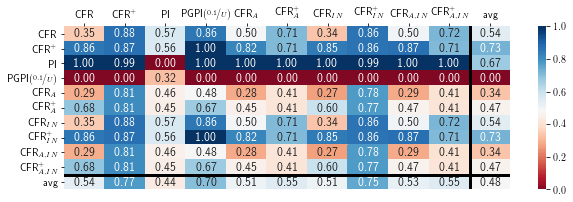

In [16]:
plt.figure(figsize=(10, 3))
br_percentage_heatmap(det_table('kuhn_3p', 'fixed'))

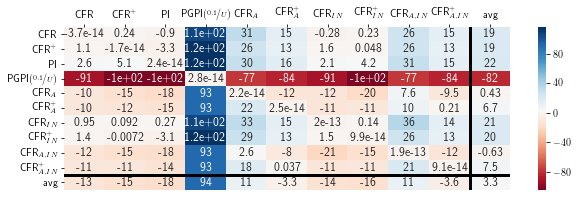

In [17]:
plt.figure(figsize=(10, 3))
heatmap(det_table('kuhn_3p', 'sim') * 1000)

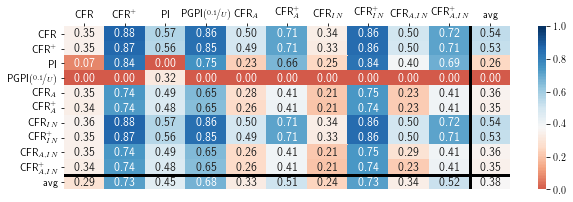

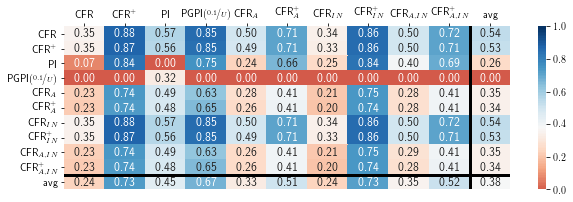

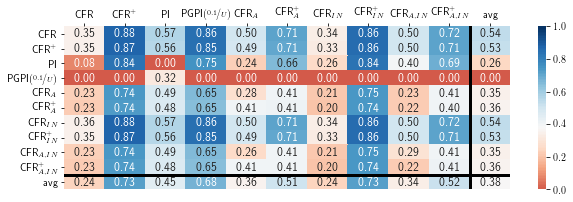

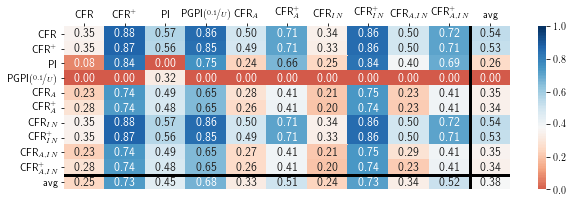

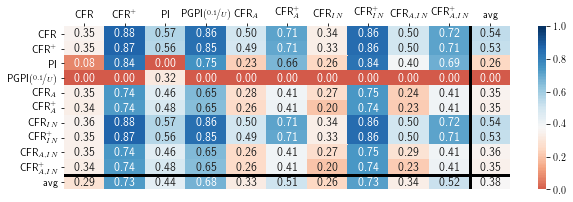

In [18]:
for seed in all_seeds():
    if not np.isnan(seed):
        plt.figure(figsize=(10, 3))
        br_percentage_heatmap(shuffled_table('kuhn_3p', seed))
        plt.show()

In [19]:
(shuffled_table_by_seed("kuhn_3p") * 1000).std().max()

18.19691372450367

In [20]:
(max_abs_diff_from_mean("kuhn_3p") * 1000).max()

32.550716

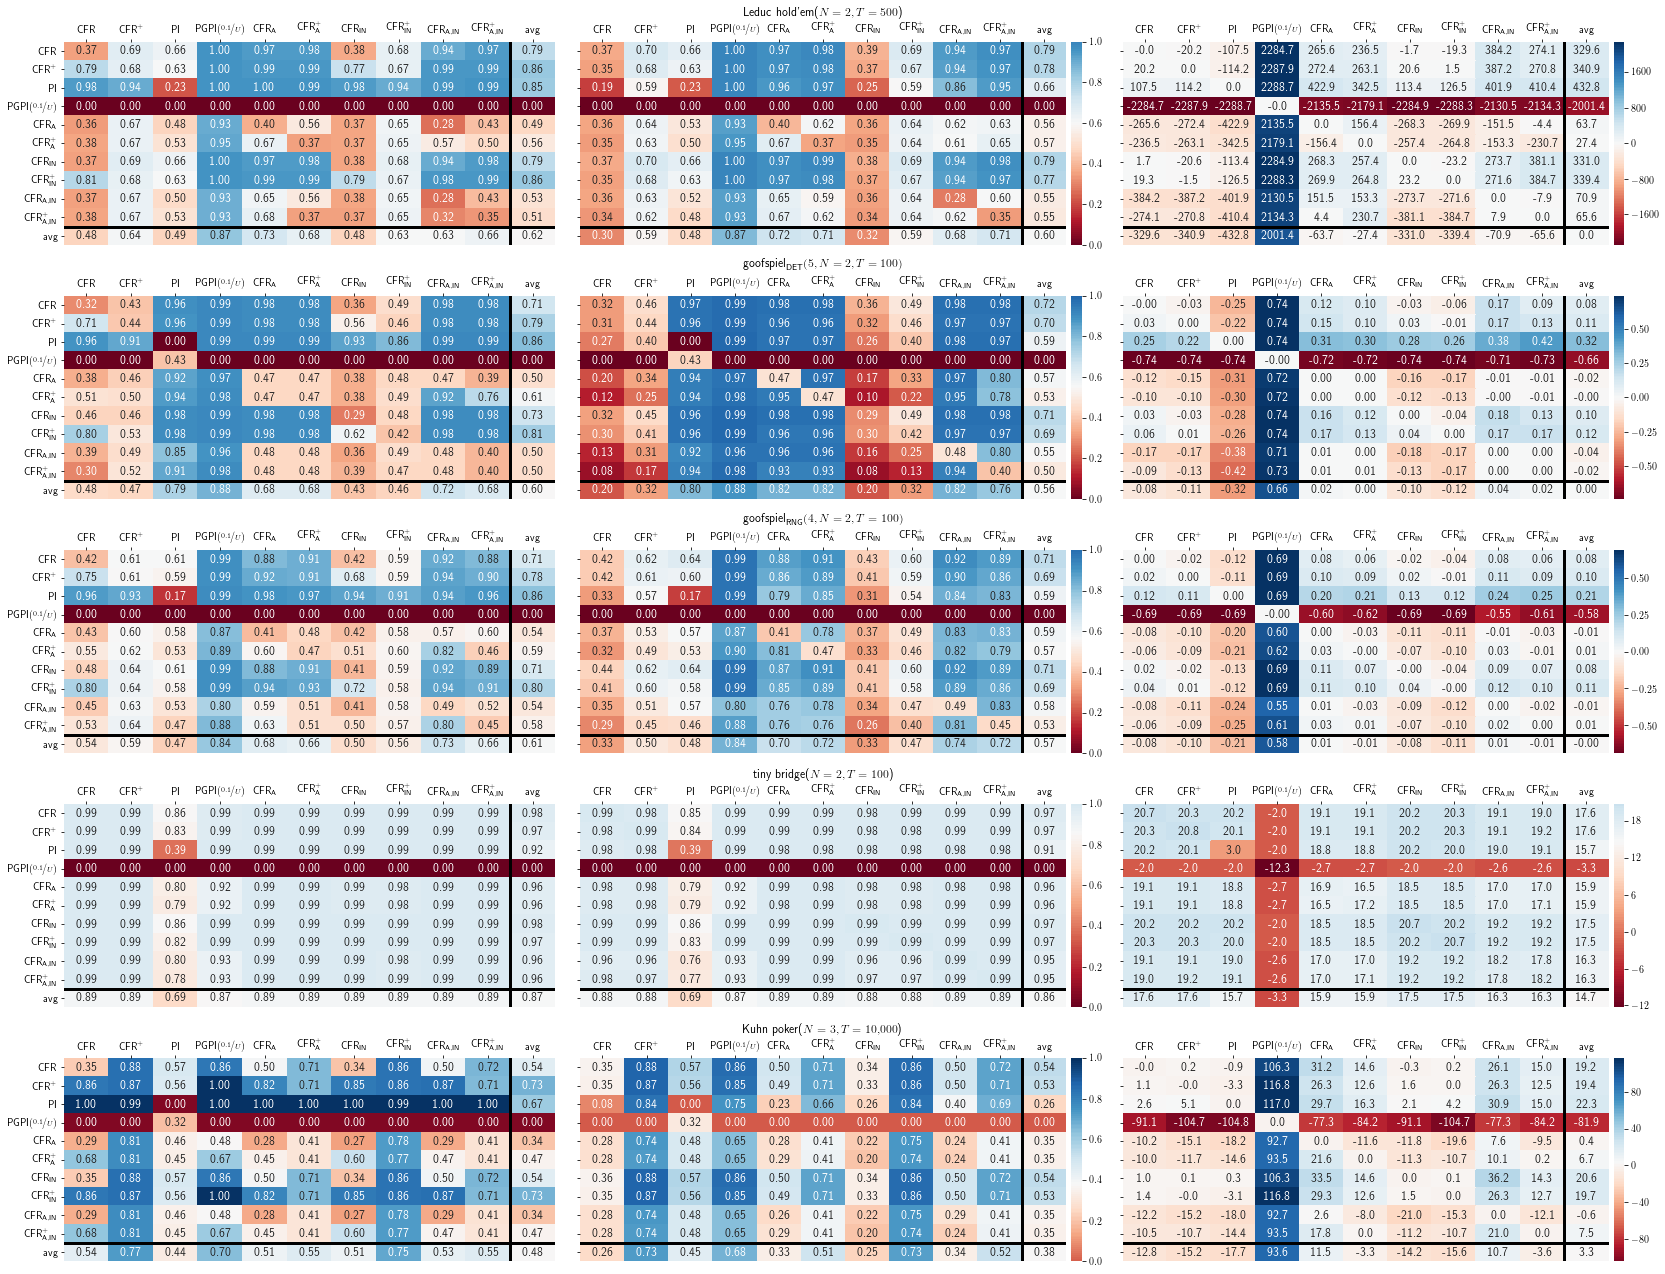

In [25]:
fig, axes_list = plt.subplots(
    len(games),
    3,
    sharex=True,
    sharey=True,
    squeeze=False,
    figsize=(23, 3.5 * len(games)),
    gridspec_kw={'width_ratios': [0.95, 1, 1]})
for i, game in enumerate(sorted(games, key=game_sort_key)):
    axes_list[i, 1].set_title(game_label(game))
    
    br_percentage_heatmap(det_table(game, 'fixed'), ax=axes_list[i, 0], cbar=False)
    br_percentage_heatmap(avg_shuffled_table(game), ax=axes_list[i, 1], cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    scale = 1000 if game == 'kuhn_3p' or game == 'leduc' else 1
    fmt = "0.2f" if game == 'goofspiel' or game == 'random_goofspiel' else "0.1f"
    heatmap(
        det_table(game, 'sim') * scale,
        ax=axes_list[i, 2],
        cbar_kws={'fraction': 0.05, 'pad': 0.01},
        fmt=fmt
    )
plt.tight_layout(0)
plt.subplots_adjust(wspace=0.05, hspace=0.25)
fig.savefig(f'results/heatmaps.aug21_2020.pdf')
plt.show()

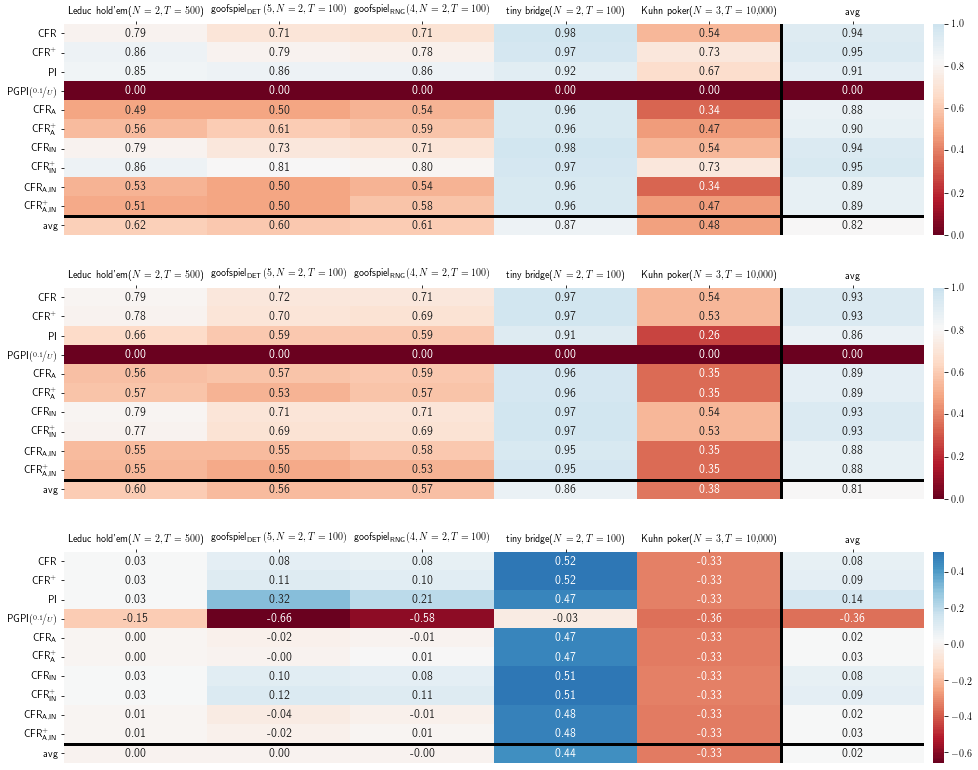

In [31]:
fig, axes_list = plt.subplots(
    3,
    1,
    sharex=True,
    sharey=True,
    squeeze=True,
    figsize=(13.5, 3.5 * 3))
br_percentage_heatmap_avg(
    data.query('mode == "fixed"').pivot(index='col_alg', columns=['row_alg', 'game_tag'], values='value').mean().unstack(),
    ax=axes_list[0],
    cbar_kws={'fraction': 0.05, 'pad': 0.01}
)
df_shuffled = data.query('mode == "shuffled"').pivot(index='seed', columns=['row_alg', 'game_tag', 'col_alg'], values='value').mean().unstack()
br_percentage_heatmap_avg(
    df_shuffled.transpose().mean().unstack(),
    ax=axes_list[1],
    cbar_kws={'fraction': 0.05, 'pad': 0.01}
)
df_sim = data.query('mode == "sim"').pivot(index='col_alg', columns=['row_alg', 'game_tag'], values='value').mean().unstack()
heatmap_avg(
    df_sim.apply(adjust_utilities, axis=1),
    ax=axes_list[2],
    cbar_kws={'fraction': 0.05, 'pad': 0.01},
    fmt = "0.2f"
)
plt.tight_layout(0)
plt.subplots_adjust(hspace=0.25)
fig.savefig(f'results/avg_heatmaps.aug22_2020.pdf')
plt.show()